In [174]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import torch
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import roc_auc_score, f1_score, precision_score

## Read and preprocess data

In [2]:
df = pd.read_csv('../data/edges.csv')
print(f'Shape before: {df.shape}')
df = df.drop_duplicates().reset_index(drop=True)
print(f'Shape after: {df.shape}')

Shape before: (51363, 2)
Shape after: (48341, 2)


In [3]:
df

,Customer,Supplier
0,Volvo,AAPICO Hitech
1,Volvo,ABC Technologies
2,Volvo,Adient plc
3,Volvo,AGC
4,Volvo,Aisin
...,...,...
48336,Unipres,voestalpine Rotec
48337,Unipres,Xiangyang Sunrise
48338,Unipres,Yakumo Manufacturing
48339,Unipres,Yamashita Rubber


Since this will be an undirected graph, we will remove the duplicates when reversing the company orders

In [4]:
df['sorted_name'] = df.apply(lambda x: min(x['Customer'], x['Supplier']) + ' ' + max(x['Customer'], x['Supplier']), axis=1)

In [5]:
df['sorted_name'].unique().shape

(48299,)

In [6]:
df = df.drop_duplicates('sorted_name')[['Customer', 'Supplier']]
df.shape

(48299, 2)

In [7]:
all_suppliers = set(df['Customer'].tolist() + df['Supplier'].tolist())

In [8]:
len(all_suppliers)

15027

In [9]:
nametoi = {name: i for i, name in enumerate(all_suppliers)}
edges = []

for _, row in df.iterrows():
    supplier1, supplier2 = row
    idx1, idx2 = nametoi[supplier1], nametoi[supplier2]
    edges.append((idx1, idx2))

In [10]:
# Create the graph
G = nx.Graph()
G.add_edges_from(edges)

In [13]:
import numpy as np

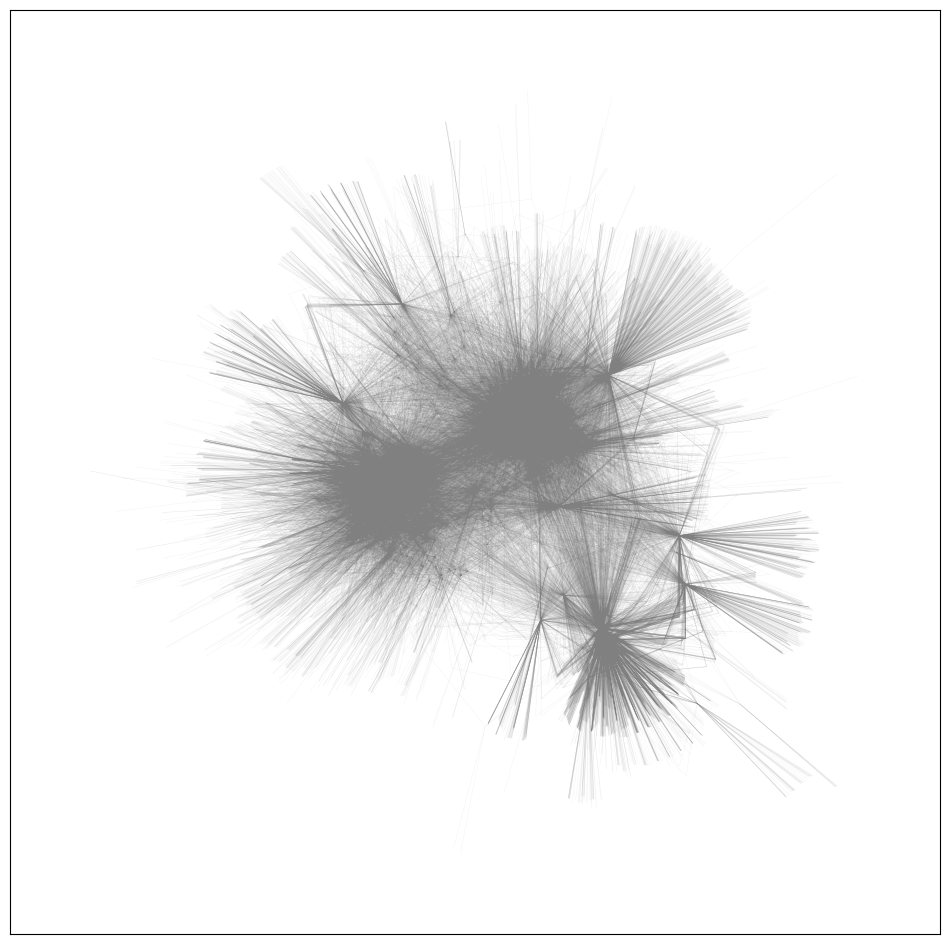

In [ ]:
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="gray", width=0.3)

In [ ]:
plt.show()

In [ ]:
nx.diameter(G)

6

In [25]:
# get the distances between all node pairs
distances = dict(nx.all_pairs_shortest_path_length(G))

In [26]:
distance_pairs = {}
for node1, nbs in distances.items():
    for node2, distance in nbs.items():
        distance_pairs[(min(node1, node2), max(node1, node2))] = distance

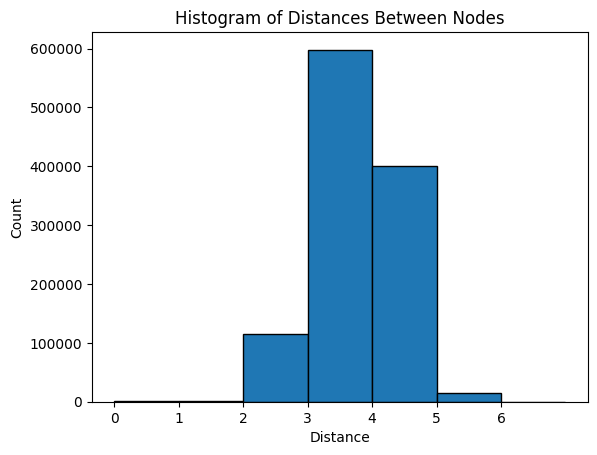

In [34]:
values = list(distance_pairs.values())[::100]
plt.hist(values, bins=range(min(values), max(values) + 2), align='mid', edgecolor='black')

plt.xticks(range(min(values), max(values) + 1))

plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Distances Between Nodes")

plt.show()

In [68]:
pos, neg = [], []

for pair, distance in tqdm(distance_pairs.items()):
    if distance == 1:
        pos.append(pair)
    if distance > 1:
        neg.append(pair)

100%|██████████| 112912878/112912878 [00:19<00:00, 5723050.12it/s]


In [71]:
print(f'There are {len(pos):,} positive edges, and {len(neg):,} negative edges')

There are 48,261 positive edges, and 1,128,496 negative edges


In [ ]:
pos_train = pos[:35_000]
pos_val = pos[35_000:40_000]
pos_test = pos[40_000:]

neg = neg[::100] # randomly sample the negative data, since we have too many of them
neg_train = neg[:140_000]
neg_val = neg[140_000:160_000]
neg_test = neg[160_000:160_000 + len(pos_test)*4]

According to the paper, each node will be assigned a color using this formula:

$$
f_{l}(i) = 1 + \min(d_x, d_y) + \frac{d}{2} \left[\frac{d}{2} + (d \% 2) - 1 \right]
$$

where *i* is a neighbouring node, *x* and *y* are the pair of nodes under consideration, $d_x$ and $d_y$ are shortest paths between *i* and *x*, *y*, respectively, and $d = d_x + d_y$.

We will now write a function to calculate this color, given *i*, *x* and *y*.


In [35]:
def get_distance(n1, n2):
    n1, n2 = min(n1, n2), max(n1, n2)
    return distance_pairs[(n1, n2)]


def get_color(i, x, y):
    dx, dy = get_distance(i, x), get_distance(i, y)
    d = dx + dy
    color = 1 + min(dx, dy) + d/2 * (d/2 + d%2 - 1)
    
    # in the paper, the authors do not apply this *4 step. 
    # But if not, how will they do the one-hot encoding
    # when the color is a float (e.g. 4.25)?
    return int(color)

We then calculate the color of every 1-hop neighbors for all the positive and negative pairs.

The authors used $64$ as maximum size of the one-hot embedding, and also the size of the subgraph embedding.

In [36]:
MAX_COLOR = 64

In [37]:
# Create adjacency list:
from collections import defaultdict
adj_list = defaultdict(list)

for node1, node2 in edges:
    if node1 not in adj_list[node2]:
        adj_list[node2].append(node1)
    if node2 not in adj_list[node1]:
        adj_list[node1].append(node2)

In [38]:
def process_data_pair(pair):
    node1, node2 = pair

    subgraph_nodes = set(adj_list[node1] + adj_list[node2] + [node1, node2])
    # subgraph_nodes.discard(node1)
    # subgraph_nodes.discard(node2)
    subgraph_nodes_to_idx = {node:i for i, node in enumerate(subgraph_nodes)}

    subgraph_edge_idx = []
    for subgraph_node in subgraph_nodes:
        nbs = adj_list[subgraph_node]
        for nb in nbs:
            # edge = [subgraph_node, nb]
            if (
                # node1 in edge or node2 in edge or # not counting the link containing the target nodes
                nb not in subgraph_nodes
            ): 
                continue
            subgraph_edge_idx.append([
                subgraph_nodes_to_idx[subgraph_node],
                subgraph_nodes_to_idx[nb],
            ])

    subgraph_edge_idx = torch.tensor(subgraph_edge_idx).t()

    one_hot_colors = []
    for subgraph_node in subgraph_nodes:
        color = get_color(subgraph_node, node1, node2)
        one_hot_color = [0] * MAX_COLOR
        one_hot_color[color] = 1
        one_hot_colors.append(one_hot_color)

    return torch.tensor(one_hot_colors), subgraph_edge_idx

Creating the train and test dataset

In [39]:
def create_data_from_node_pairs(pairs, labels):
    dataset = []
    for pair, label in tqdm(zip(pairs, labels)):
        subgraph_node_features, subgraph_edge_idx = process_data_pair(pair)
        data = Data(
            x=subgraph_node_features, 
            edge_index=subgraph_edge_idx,
            y=torch.tensor([label])
        )
        dataset.append(data)
    return dataset

In [40]:
train_dataset = create_data_from_node_pairs(
    pairs=pos_train + neg_train,
    labels=[1.0]*len(pos_train) + [0.0]*len(neg_train)
)
# torch.save(train_dataset, '../data/train_dataset.pt')

175000it [06:13, 468.70it/s] 


In [41]:
val_dataset = create_data_from_node_pairs(
    pairs=pos_val + neg_val,
    labels=[1.0]*len(pos_val) + [0.0]*len(neg_val)
)

25000it [00:33, 745.09it/s] 


# Model training

The model is defined as a 3-layer GCN. The input dim , hidden size, and output dim of each layer is equal to the one-hot embedding size.

The original paper from Kipf and Welling (2017) used ReLU activation, but in this paper the authors used sigmoid instead.

In [155]:
class LinkPredictionModel(torch.nn.Module):
    def __init__(self, gnn_input_dim, gnn_hidden_dim, gnn_output_dim):
        super(LinkPredictionModel, self).__init__()
        # GNN layers
        self.conv1 = GCNConv(gnn_input_dim, gnn_hidden_dim)
        self.conv2 = GCNConv(gnn_hidden_dim, gnn_hidden_dim)
        self.conv3 = GCNConv(gnn_hidden_dim, gnn_output_dim)
        # Binary classifier layer
        self.fc = torch.nn.Linear(gnn_output_dim, 1)

    def forward(self, x, edge_index, batch):
        # GNN processing
        x = self.conv1(x, edge_index)
        x = F.sigmoid(x)

        x = self.conv2(x, edge_index)
        x = F.sigmoid(x)

        x = self.conv3(x, edge_index)
        x = F.sigmoid(x)

        # Global pooling to get subgraph embeddings
        x = global_mean_pool(x, batch)

        # Binary classification
        output = self.fc(x)
        return output

In [156]:
model = LinkPredictionModel(gnn_input_dim=MAX_COLOR, gnn_hidden_dim=MAX_COLOR, gnn_output_dim=MAX_COLOR)

In [ ]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)
model.train()
epochs = 50

In [158]:
# # Get a single batch from the train_dataloader
# for batch in train_dataloader:
#     print("Node features (x):", batch.x)
#     print("Edge index:", batch.edge_index)
#     print("Batch vector:", batch.batch)
#     print("Labels (y):", batch.y)
#     print('========')
#     print("Node features (x) shape:", batch.x.shape)
#     print("Edge index shape:", batch.edge_index.shape)
#     print("Batch vector shape:", batch.batch.shape)
#     print("Labels (y) shape:", batch.y.shape)
#     break

In [164]:
train_loss_old = train_loss.copy()
val_loss_old = val_loss.copy()

In [ ]:
train_loss, val_loss = [], []

for epoch in range(epochs):
    model.train()
    
    # Training phase
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        output = model(batch.x.float(), batch.edge_index.int(), batch.batch)

        loss = criterion(output, batch.y.float().unsqueeze(-1))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss.append(total_loss / len(train_dataloader))
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            output = model(batch.x.float(), batch.edge_index.int(), batch.batch)
            loss = criterion(output, batch.y.float().unsqueeze(-1))
            total_val_loss += loss.item()

    val_loss.append(total_val_loss / len(val_dataloader))
    
    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}')

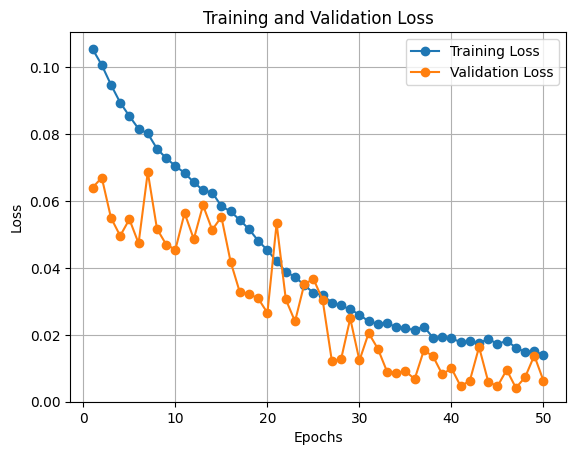

In [172]:
plt.plot(range(1, epoch + 2), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, epoch + 2), val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0)  # Set the y-axis to start at 0
plt.legend()
plt.grid()
plt.show()

# Evaluating on test dataset

In [175]:
all_auc = []
all_f1 = []
all_precision = []

for i in range(1, 5):
    subset_neg_test = neg_test[:len(neg_test) * i // 4]

    test_dataset = create_data_from_node_pairs(
        pairs=pos_test + subset_neg_test,
        labels=[1.0] * len(pos_test) + [0.0] * len(subset_neg_test)
    )

    all_labels = []
    all_probs = []

    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

    with torch.no_grad():
        for batch in test_dataloader:
            logits = model(batch.x.float(), batch.edge_index.int(), batch.batch)
            probs = torch.sigmoid(logits).squeeze()

            all_labels.append(batch.y.float())
            all_probs.append(probs)

    all_labels = torch.cat(all_labels).cpu().numpy()
    all_probs = torch.cat(all_probs).cpu().numpy()

    # Calculate AUC score
    auc_score = roc_auc_score(all_labels, all_probs)
    print(f"Iteration {i}, Negative samples: {len(subset_neg_test)}, AUC Score: {auc_score:.4f}")
    all_auc.append(auc_score)

    # Find the best threshold for F1 score
    best_f1 = 0
    best_precision = 0
    best_threshold = 0
    thresholds = torch.arange(0, 1.01, 0.01).numpy()

    for threshold in thresholds:
        predicted_labels = (all_probs >= threshold).astype(float)
        f1 = f1_score(all_labels, predicted_labels)
        precision = precision_score(all_labels, predicted_labels)

        if f1 > best_f1:
            best_f1 = f1
            best_precision = precision
            best_threshold = threshold

    all_f1.append(best_f1)
    all_precision.append(best_precision)

    print(f'pos/neg ratio 1/{i}:')
    print(f"F1 score: {best_f1:.4f}, precision: {best_precision:.4f}, AUC: {auc_score}")
    print('==========')

16522it [04:03, 67.71it/s]  


Iteration 1, Negative samples: 8261, AUC Score: 0.9999
pos/neg ratio 1/1:
F1 score: 0.9987, precision: 0.9992, AUC: 0.9999487867973271


24783it [04:09, 99.18it/s]  


Iteration 2, Negative samples: 16522, AUC Score: 0.9999
pos/neg ratio 1/2:
F1 score: 0.9983, precision: 0.9983, AUC: 0.9999443908142651


33044it [04:12, 130.76it/s] 


Iteration 3, Negative samples: 24783, AUC Score: 0.9999
pos/neg ratio 1/3:
F1 score: 0.9980, precision: 0.9977, AUC: 0.9999419437170274


41305it [04:08, 166.34it/s] 


Iteration 4, Negative samples: 33044, AUC Score: 0.9999
pos/neg ratio 1/4:
F1 score: 0.9945, precision: 0.9907, AUC: 0.9998905180418398


In [176]:
jaccard_auc = [0.6671611928989968,
 0.6679616378992285,
 0.6675719742783746,
 0.6665060046712902]

jaccard_f1 = [0.3333333333333333, 0.4, 0.5, 0.6666666666666666]

jaccard_precision = [0.2, 0.25, 0.3333333333333333, 0.5]